<a href="https://colab.research.google.com/github/mauricioaalmeida/ONE-ML/blob/main/ONE_Classifica%C3%A7%C3%A3o_Valida%C3%A7%C3%A3o_m%C3%A9tricas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='dark'>**Classificação: Validação de modelos e métricas de avaliação**</h1>

### Projeto

Uma empresa de empréstimo de automóveis está passando por uma situação complicada, com alta demanda para uma frota reduzida de veículos e alto número de inadimplentes, trazendo um prejuízo grande para a empresa.

Nós fomos contratados para buscar melhorias na identificação de inadimplentes. A análise dos clientes atualmente é feita de forma manual, cliente por cliente, tomando muito tempo e ainda assim a detecção de inadimplentes é muito imprecisa.

Nossa tarefa é utilizar os dados fornecidos pela empresa para **classificar** os clientes em adimplentes e inadimplentes.

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score, precision_recall_curve


from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression



import pickle

## <font color='dark'>Classificando dados</h1>

### Criando um modelo inicial

In [9]:
url = 'https://raw.githubusercontent.com/mauricioaalmeida/ONE-ML/refs/heads/main/data/emp_automovel.csv'
dados = pd.read_csv(url)

In [10]:
dados.head()

,receita_cliente,anuidade_emprestimo,anos_casa_propria,telefone_trab,avaliacao_cidade,score_1,score_2,score_3,score_social,troca_telefone,inadimplente
0,12600.0,3569.400000,12.157324,1,2.0,0.057153,0.527227,0.513171,0.117428,2545.0,0
1,9000.0,2722.188351,7.000000,0,2.0,0.657661,0.285898,0.614414,0.222700,495.0,0
2,15750.0,4477.500000,12.000000,0,2.0,0.501213,0.695423,0.513171,0.117428,1212.0,0
3,9000.0,1309.050000,12.157324,0,3.0,0.501213,0.155973,0.513171,0.117428,515.0,0
4,7650.0,1125.000000,12.157324,0,2.0,0.294328,0.152076,0.513171,0.117428,162.0,0


In [11]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54025 entries, 0 to 54024
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   receita_cliente      54025 non-null  float64
 1   anuidade_emprestimo  54025 non-null  float64
 2   anos_casa_propria    54025 non-null  float64
 3   telefone_trab        54025 non-null  int64  
 4   avaliacao_cidade     54025 non-null  float64
 5   score_1              54025 non-null  float64
 6   score_2              54025 non-null  float64
 7   score_3              54025 non-null  float64
 8   score_social         54025 non-null  float64
 9   troca_telefone       54025 non-null  float64
 10  inadimplente         54025 non-null  int64  
dtypes: float64(9), int64(2)
memory usage: 4.5 MB


In [12]:
colunas = dados.columns.tolist()
col_categoricas = dados.select_dtypes(include=['object']).columns.tolist()
col_numericas = dados.select_dtypes(include=['number']).columns.tolist()
col_alvo='inadimplente'
colunas.remove(col_alvo)
print (col_categoricas)
print (col_numericas)

[]
['receita_cliente', 'anuidade_emprestimo', 'anos_casa_propria', 'telefone_trab', 'avaliacao_cidade', 'score_1', 'score_2', 'score_3', 'score_social', 'troca_telefone', 'inadimplente']


In [13]:
x = dados.drop(col_alvo, axis=1)
y = dados[col_alvo]

## Árvore de Decisão


In [14]:
# Testando com todos os dados
tree = DecisionTreeClassifier()
tree.fit(x, y)
tree.score(x, y)

1.0

In [15]:
print(f'Acurácia no conjunto completo  : {tree.score(x, y)*100:.4f}%')


Acurácia no conjunto completo  : 100.0000%


Separação entre Treino, Validação e Teste

In [16]:
x, x_test, y, y_test = train_test_split(x, y, test_size=0.15, stratify=y, random_state=5)
x_train, x_val, y_train, y_val = train_test_split(x, y, stratify=y, random_state=5)

In [17]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
print(f'Acurácia no conjunto de treino : {tree.score(x_train, y_train)*100:.4f}%')
print(f'Acurácia no conjunto de valid  : {tree.score(x_val, y_val)*100:.4f}%')

Acurácia no conjunto de treino : 100.0000%
Acurácia no conjunto de valid  : 84.8707%


In [18]:
tree = DecisionTreeClassifier(max_depth=10)
tree.fit(x_train, y_train)
print(f'Acurácia no conjunto de treino : {tree.score(x_train, y_train)*100:.4f}%')
print(f'Acurácia no conjunto de valid  : {tree.score(x_val, y_val)*100:.4f}%')

Acurácia no conjunto de treino : 92.0587%
Acurácia no conjunto de valid  : 90.5583%


##Fazendo uma Matriz de Confusão

In [19]:
y_previsto = tree.predict(x_val)
matriz_confusao = confusion_matrix(y_val, y_previsto)
print(matriz_confusao)

[[10357   122]
 [  962    40]]


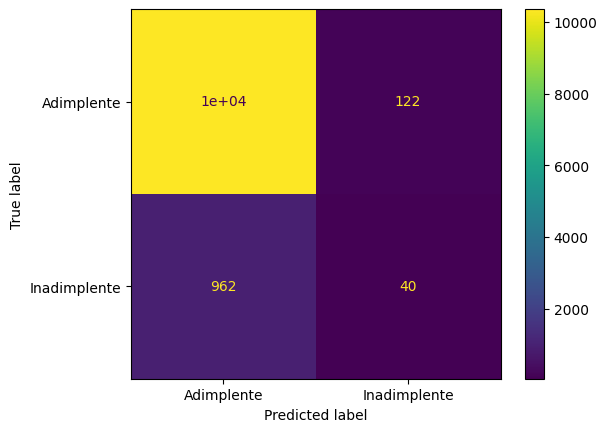

In [20]:
visualizacao = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=['Adimplente','Inadimplente'])
visualizacao.plot();


O modelo está performando com boa acurácia para os Adimplentes, mas está muito mal para os inadimplentes com apenas 40 acertos em 1002

### Random Forest

In [21]:
modelo_rf = RandomForestClassifier(max_depth = 7)
modelo_rf.fit(x_train, y_train)
print(f'Acurácia no conjunto de treino : {modelo_rf.score(x_train, y_train)*100:.4f}%')
print(f'Acurácia no conjunto de valid  : {modelo_rf.score(x_val, y_val)*100:.4f}%')

Acurácia no conjunto de treino : 91.3008%
Acurácia no conjunto de valid  : 91.2725%


In [22]:
y_previsto_rf = modelo_rf.predict(x_val)
matriz_confusao_rf = confusion_matrix(y_val, y_previsto_rf)
print(matriz_confusao_rf)

[[10479     0]
 [ 1002     0]]


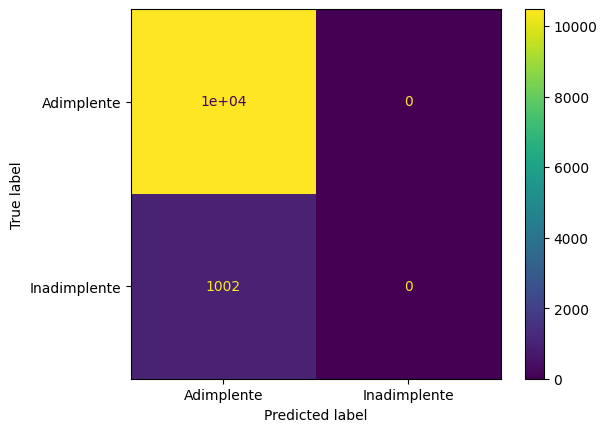

In [23]:
visualizacao = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao_rf, display_labels=['Adimplente','Inadimplente'])
visualizacao.plot();

## Avaliando Acurácia, Precisão, Recall e F-Score


In [24]:
print('Modelo Árvore:')
print('==============')
print(f'Acurácia : {accuracy_score(y_val, y_previsto)*100:.4f}%')
print(f'Recall    : {recall_score(y_val, y_previsto)*100:.4f}%')
print(f'Precisão  : {precision_score(y_val, y_previsto)*100:.4f}%')
print(f'F1-Score  : {f1_score(y_val, y_previsto)*100:.4f}%')

print(classification_report(y_val, y_previsto))

Modelo Árvore:
Acurácia : 90.5583%
Recall    : 3.9920%
Precisão  : 24.6914%
F1-Score  : 6.8729%
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     10479
           1       0.25      0.04      0.07      1002

    accuracy                           0.91     11481
   macro avg       0.58      0.51      0.51     11481
weighted avg       0.86      0.91      0.87     11481



In [25]:
print('Modelo Random Forest:')
print('====================')
print(f'Acurácia : {accuracy_score(y_val, y_previsto_rf)*100:.4f}%')
print(f'Recall    : {recall_score(y_val, y_previsto_rf)*100:.4f}%')
print(f'Precisão  : {precision_score(y_val, y_previsto_rf)*100:.4f}%')
print(f'F1-Score  : {f1_score(y_val, y_previsto_rf)*100:.4f}%')

Modelo Random Forest:
Acurácia : 91.2725%
Recall    : 0.0000%
Precisão  : 0.0000%
F1-Score  : 0.0000%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Curva ROC

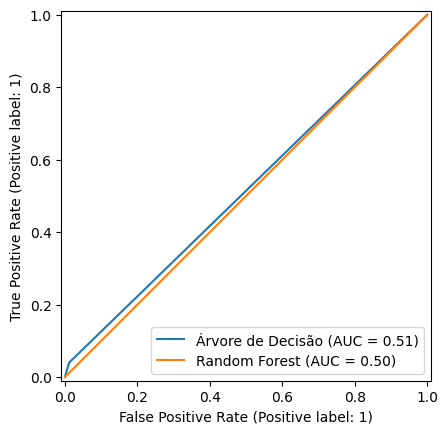

In [26]:
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_val, y_previsto, name = 'Árvore de Decisão', ax=ax)
RocCurveDisplay.from_predictions(y_val, y_previsto_rf, name = 'Random Forest', ax=ax)
plt.show()

In [27]:
print('Modelo Árvore:')
print('==============')
print(f'Acurácia : {accuracy_score(y_val, y_previsto)*100:.4f}%')
print(f'Recall    : {recall_score(y_val, y_previsto)*100:.4f}%')
print(f'Precisão  : {precision_score(y_val, y_previsto)*100:.4f}%')
print(f'F1-Score  : {f1_score(y_val, y_previsto)*100:.4f}%')
print(f'ROC AUC   : {roc_auc_score(y_val, y_previsto)*100:.4f}%')

Modelo Árvore:
Acurácia : 90.5583%
Recall    : 3.9920%
Precisão  : 24.6914%
F1-Score  : 6.8729%
ROC AUC   : 51.4139%


In [28]:
print('Modelo Random Forest:')
print('====================')
print(f'Acurácia : {accuracy_score(y_val, y_previsto_rf)*100:.4f}%')
print(f'Recall    : {recall_score(y_val, y_previsto_rf)*100:.4f}%')
print(f'Precisão  : {precision_score(y_val, y_previsto_rf)*100:.4f}%')
print(f'F1-Score  : {f1_score(y_val, y_previsto_rf)*100:.4f}%')
print(f'ROC AUC   : {roc_auc_score(y_val, y_previsto_rf)*100:.4f}%')

Modelo Random Forest:
Acurácia : 91.2725%
Recall    : 0.0000%
Precisão  : 0.0000%
F1-Score  : 0.0000%
ROC AUC   : 50.0000%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ambos os modelos estão muito mal


### Curva de Precisão x Recall

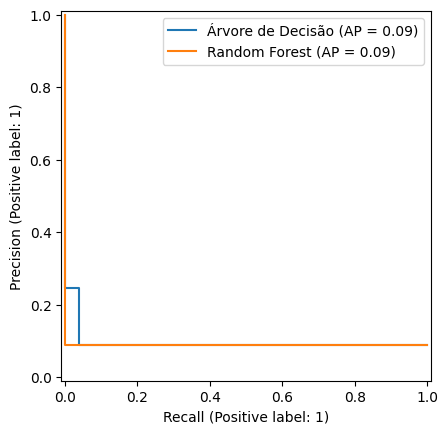

In [29]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_val, y_previsto, name = 'Árvore de Decisão', ax=ax)
PrecisionRecallDisplay.from_predictions(y_val, y_previsto_rf, name = 'Random Forest', ax=ax)
plt.legend(loc = 'upper right')
plt.show()

In [30]:
print('Indicador    :   Árvore      |  Random Forest')
print('=========================================================')
print(f'Acurácia     : {accuracy_score(y_val, y_previsto)*100:8.4f}%     |    {accuracy_score(y_val, y_previsto_rf)*100:8.4f}%')
print(f'Recall       : {recall_score(y_val, y_previsto)*100:8.4f}%     |    {recall_score(y_val, y_previsto_rf)*100:8.4f}%')
print(f'Precisão     : {precision_score(y_val, y_previsto)*100:8.4f}%     |    {precision_score(y_val, y_previsto_rf)*100:8.4f}%')
print(f'F1-Score     : {f1_score(y_val, y_previsto)*100:8.4f}%     |    {f1_score(y_val, y_previsto_rf)*100:8.4f}%')
print(f'ROC AUC      : {roc_auc_score(y_val, y_previsto)*100:8.4f}%     |    {roc_auc_score(y_val, y_previsto_rf)*100:8.4f}%')
print(f'PR AUC       : {average_precision_score(y_val, y_previsto)*100:8.4f}%     |    {average_precision_score(y_val, y_previsto_rf)*100:8.4f}%')

Indicador    :   Árvore      |  Random Forest
Acurácia     :  90.5583%     |     91.2725%
Recall       :   3.9920%     |      0.0000%
Precisão     :  24.6914%     |      0.0000%
F1-Score     :   6.8729%     |      0.0000%
ROC AUC      :  51.4139%     |     50.0000%
PR AUC       :   9.3647%     |      8.7275%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [31]:
print(classification_report(y_val, y_previsto))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     10479
           1       0.25      0.04      0.07      1002

    accuracy                           0.91     11481
   macro avg       0.58      0.51      0.51     11481
weighted avg       0.86      0.91      0.87     11481



In [32]:
print(classification_report(y_val, y_previsto_rf))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     10479
           1       0.00      0.00      0.00      1002

    accuracy                           0.91     11481
   macro avg       0.46      0.50      0.48     11481
weighted avg       0.83      0.91      0.87     11481



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# K-Fold


In [46]:

modelo_tree = DecisionTreeClassifier(max_depth = 5)
kf = KFold(n_splits=5, shuffle=True, random_state=5)
cv_resultados = cross_validate(modelo_tree, x, y, cv=kf)
cv_resultados

{'fit_time': array([0.21770954, 0.16562176, 0.16954327, 0.29526973, 0.31152058]),
 'score_time': array([0.00497246, 0.00460601, 0.00849199, 0.01194167, 0.00443006]),
 'test_score': array([0.91714752, 0.91082317, 0.9106054 , 0.91550523, 0.90516115])}

In [47]:
media = cv_resultados['test_score'].mean()
desvio_padrao = cv_resultados['test_score'].std()
print(f'Intervalo de confianca: [{media-2*desvio_padrao:.4f}, {min(media+2*desvio_padrao, 1):.4f}]')

Intervalo de confianca: [0.9034, 0.9203]


## Validação Cruzada com Recall

In [78]:

def intervalo_conf(resultados,score_list):
  r = {}
  for score in score_list:
    media = resultados[score].mean()
    desvio_padrao = resultados[score].std()
    r[score] = f'[ {media-2*desvio_padrao:.6f}, {min(media+2*desvio_padrao, 1):.6f} ]'
  return r

In [ ]:
print(f'Intervalo de confianca: [{media-2*desvio_padrao:.4f}, {min(media+2*desvio_padrao, 1):.4f}]')

In [70]:

modelo_tree = DecisionTreeClassifier(max_depth = 5)
kf = KFold(n_splits=5, shuffle=True, random_state=5)
cv_resultados = cross_validate(modelo_tree, x, y, cv=kf, scoring = ('accuracy', 'recall','precision', 'f1', 'roc_auc'))
cv_resultados

{'fit_time': array([0.17458749, 0.17249155, 0.16858745, 0.16914463, 0.16547132]),
 'score_time': array([0.02724338, 0.02909636, 0.03044438, 0.02672148, 0.02686167]),
 'test_accuracy': array([0.91714752, 0.91082317, 0.9106054 , 0.91550523, 0.90527003]),
 'test_recall': array([0.00264201, 0.00247525, 0.00738007, 0.01174935, 0.00115607]),
 'test_precision': array([0.25      , 0.13333333, 0.3       , 0.32142857, 0.14285714]),
 'test_f1': array([0.00522876, 0.00486027, 0.01440576, 0.02267003, 0.00229358]),
 'test_roc_auc': array([0.67005308, 0.66406198, 0.65864822, 0.66335139, 0.64754816])}

In [71]:
intervalo_conf(cv_resultados,['test_accuracy', 'test_recall','test_precision', 'test_f1', 'test_roc_auc'])


{'test_accuracy': '[ 0.9035, 0.9202 ]',
 'test_recall': '[ -0.0028, 0.0130 ]',
 'test_precision': '[ 0.0731, 0.3860 ]',
 'test_f1': '[ -0.0053, 0.0251 ]',
 'test_roc_auc': '[ 0.6457, 0.6758 ]'}

## Estratificando os dados

In [72]:
dados['inadimplente'].value_counts(normalize=True)

,proportion
inadimplente,
0,0.912707
1,0.087293


In [79]:

modelo_tree = DecisionTreeClassifier(max_depth = 5)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5, )
cv_resultados = cross_validate(modelo_tree, x, y, cv=skf, scoring = ('accuracy', 'recall','precision', 'f1', 'roc_auc'))
intervalo_conf(cv_resultados,['test_accuracy', 'test_recall','test_precision', 'test_roc_auc','test_f1' ])

{'test_accuracy': '[ 0.911230, 0.911945 ]',
 'test_recall': '[ -0.002574, 0.009058 ]',
 'test_precision': '[ -0.031735, 0.325910 ]',
 'test_roc_auc': '[ 0.643809, 0.672186 ]',
 'test_f1': '[ -0.004952, 0.017621 ]'}

**GroupKFold**

O método GroupKFold é uma variação da validação cruzada KFold tradicional e é utilizado quando os dados possuem alguma estrutura de grupo ou dependência que não deve ser quebrada, geralmente uma característica em uma das colunas da base de dados.

Essa abordagem utiliza uma estratégia de separação dos dados para que os registros pertencentes a um grupo específico sejam mantidas juntas durante as divisões do KFold, garantindo que não sejam separadas entre os conjuntos de treinamento e validação. Isso é útil para evitar possíveis vieses e garantir que o modelo generalize para grupos desconhecidos, ou seja. Mesmo que não tenha um dado do grupo no conjunto de treinamento, o modelo precisará ter um bom desempenho ao prever o resultado para os dados daquele grupo.

**Leave-p-out**

O método Leave-p-out funciona de maneira diferente do método KFold. Ao invés de dividir o conjunto de dados em uma quantidade fixada de conjuntos, será escolhida uma quantidade 'p' de elementos para serem deixados de fora do treinamento. Os dados serão treinados em todo o restante e validados apenas nos 'p' elementos. Esse processo é repetido até que todos os dados sejam utilizados como dados de validação. O resultado final pode ser considerado a média dos resultados obtidos nos modelos, assim como é feito na validação cruzada tradicional.

Isso proporciona uma validação bem mais completa, já que considera todas as combinações possíveis de dados de treino e validação. Porém, é muito mais custosa computacionalmente, já que serão criados muitos modelos e isso aumenta a quantidade conforme o conjunto de dados seja muito grande e o valor escolhido para 'p' seja pequeno.


**Leave-one-out**

O método Leave-one-out é uma forma especial do Leave-p-out, onde é escolhido o valor de p=1. Dessa maneira, apenas uma amostra é reservada para validação e todos os outros dados são escolhidos para treinamento. Esse processo é repetido para todas as amostras da base de dados. Isso significa que, se houver 1000 linhas na base de dados, serão treinados 1000 modelos distintos.

É de se esperar que esse método demanda muito computacionalmente, pela criação de um modelo para cada linha da base de dados. Portanto, ele é indicado somente nos casos em que a base de dados é muito pequena. Nessas situações, é interessante utilizar a maior quantidade de dados possível para treinamento, para que o modelo consiga entender o padrão dos dados. Outra estratégia de validação cruzada removeria muitos dados que seriam úteis no treino.

Caso deseje saber mais sobre outros métodos de validação disponíveis na biblioteca Scikit-Learn, você pode consultar a documentação Validação cruzada: avaliando o desempenho do estimador.

Caso queira criar uma visualização para ter um melhor entendimento de como foi realizada a divisão dos dados em algum projeto, seja com o KFold, StratifiedKFold ou GroupKFold, você pode explorar a documentação Visualizando o comportamento de validação cruzada no scikit-learn.